In [1]:
# ## Funciones e importaciones
import numpy as np
import matplotlib.pyplot as plt
import math as math
import pandas as pd
from scipy.integrate import simps
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
'__Fuente de gráficos__'
#plt.rcParams['font.family'] = 'Times New Roman'
#plt.rcParams['font.size'] = '18'
#plt.rcParams['legend.title_fontsize'] = '4'
#plt.rcParams['figure.figsize'] = [7,5]
dpi=200
form='png'

In [3]:
e = math.e
pi = math.pi


'__Definición de funciones__'

def find_nearest(array, value):
    '''
    Recibe un array y un valor; devuelve el valor más cercano al recibido
    '''
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def find_nearest_pos(array, value):
    '''
    Recibe un array y un valor; devuelve el índice del elemento con el valor más cercano al recibido
    '''
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def eqX(y):
    '''
    Devuelve concentración de equilibrio en fase sólida a partir de una concentración en fase líquida
    '''
    y = y
    KeqX = [15.80011045, 32.02907632, 5.735438305, 0.053726466, 1.972131456]
    eqX = KeqX[0]*KeqX[1]*y/(1+KeqX[1]*y)+KeqX[2] * KeqX[3]*(y-KeqX[4])/(1-KeqX[3]*(y-KeqX[4]))
    return eqX

def m(y):
    '''
    Devuelve el valor del coeficiente de distribución para una determinada concentración en fase líquida
    '''
    m = y/eqX(y)
    return m

def batch(F, t):
    '''
    '''
    x = F[0]
    y = F[1]

    dxdt = -K * (x - eqX(y))
    dydt = (1-eps)/eps * K * (x - eqX(y))

    return [dxdt, dydt]

def column(F, t):
    '''
    '''

    x = F[::2]
    y = F[1::2]

    y[0] = 0

    dFdt = np.empty_like(F)

    dxdt = dFdt[::2]
    dydt = dFdt[1::2]

    '__Fase Sólida_______________________________________________________________________________'

    # A lo largo del extractor el sólido se mantiene estático por lo que ambos términos
    # de transporte son iguales a cero y solo se rige por el término de transferencia de masa

    dxdt[:] = - K * (x[:] - eqX(y[:]))


    '__Fase Líquida_______________________________________________________________________________'
    
    dydt[0]        = 0      

    # A lo largo del extractor se considera la ecuación general
    difusionL      = eps * Dax * np.diff(y[:], 2)/dz**2
    conveccionL    = L/A * np.diff(y[:-1], 1)/dz
    transferenciaL = (1-eps)*K*(x[1:-1] - eqX(y[1:-1]))

    dydt[1:-1]     = (
        + difusionL 
        - conveccionL 
        + transferenciaL
        )/eps

    dydt[-1]       = (
        + eps * Dax * (2*y[-1]-2*y[-2])/(dz**2)
        - L/A*(y[-1]-y[-2])/dz 
        + (1-eps)*K*(x[-1] - eqX(y[-1]))
        )/eps
        
    '____________________________________________________________________________________________'

    return dFdt

def countercurrent(F, t):
    '''
    '''
    x = F[::2]
    y = F[1::2]

    x[-1] = porcentajeAC*dens
    y[0]= F[1]

    dFdt = np.empty_like(F)

    dxdt = dFdt[::2]
    dydt = dFdt[1::2]

    '____________________________________________________________________________________________'

    dxdt[0] = (S/A*(x[1]-x[0])/dz - (1-eps) * K*(x[0] - eqX(y[0])))/(1-eps)
    
    # A lo largo del extractor se considera la ecuación general
    conveccionS    = S/A * np.diff(x[1:], 1)/dz
    transferenciaS = (1-eps) * K * (x[1:-1] - eqX(y[1:-1]))
    
    dxdt[1:-1]     = (
        + conveccionS 
        - transferenciaS
        )/(1-eps)
    # En el punto de ingreso de sólidos (z = L) no hay variación en función del tiempo
    dxdt[-1]       = 0

    '____________________________________________________________________________________________'
    
    # En el punto de ingreso de solvente (z = 0) se considera que no hay acumulación
    dydt[0]       = 0
        

    # A lo largo del extractor se considera la ecuación general
    difusionL      = Dax * np.diff(y[:], 2)/dz**2
    conveccionL    = L/A * np.diff(y[:-1], 1)/dz
    transferenciaL = (1-eps)*K*(x[1:-1] - eqX(y[1:-1]))

    dydt[1:-1]     = (
        + difusionL 
        - conveccionL 
        + transferenciaL
         )/eps

    dydt[-1]       = (
        + eps * Dax * (2*y[-1] - 2*y[-2])/(dz**2)
        - L/A*(y[-1]-y[-2])/dz 
        + (1-eps)*K*(x[-1] - eqX(y[-1]))
         )/eps
    '____________________________________________________________________________________________'

    return dFdt

def Dab_f(T, visc, rad):
    kb = 1.38*10**-23 # Constante de Boltzmann
    Dab = kb*T/(6*pi*visc*rad)
    return Dab

def Re_f(L, A, Deq, visc, eps):
    Re = (L/A)*Deq*densL/(visc*(1-eps))
    return Re

def Sh_f(Re, Sc):
    ShL = (0.765/(Re**0.82) + 0.365/(Re**0.386))*Re*(Sc**(1/3))/eps
    return ShL

def Sc_f(visc, densL, Dab):
    Sc = visc/(densL*Dab)
    return Sc

def Dax_f(Deq, L, A, eps, Pe):
    Dax = Deq*(L/A)/(eps*Pe)
    return Dax

def Bi_f(kL, a, Deff):
    Bi = m(1.9)*kL*a/Deff
    return Bi

def Pe_f(Re, eps):
    Pe = 0.2/eps + 0.011/eps * math.pow(eps*Re, 0.48)
    return Pe

def kL_f(Sh, Dab, a):
    kL = Sh*Dab/a
    return kL

def Shod_f(Bi, phi):
    exp = 1.0189+0.02736*phi
    Shod = 2*(2.0654+0.41309*phi)*( 1 + (1.9957 + 0.3238*phi)/(Bi**exp) )**(-1)
    return Shod

def error_porcentual(modelo):

    error_porcentual = 0

    for i, dato in enumerate(concentracion_experimental):

        tiempo = tiempo_experimental[i]
        posicion_t = find_nearest_pos(t/60,tiempo)
        
        error = abs((modelo[posicion_t, 1]-dato)/dato)
        error_porcentual += error

    return error_porcentual/(i+1)*100


# ## Parámetros Generales

'__Datos Cinéticos Experimentales'
tiempo_experimental = [1,5,10,15,30,46,80,108,142,168,192,1263,1608]                             # min
concentracion_experimental = [0.11,0.21,0.3,0.46,0.72,0.93,1.3,1.37,1.59,1.62,1.58,1.64,1.76]    # g/L
datos_experimentales = [[tiempo_experimental],[concentracion_experimental]]

# Temperatura de trabajo
T = 25 + 273

# Definición de propiedades
porcentajeAC = 0.06                                                 # Porcentaje de Ácido Carnósico
dens = 557.82                                                       # Densidad del sólido
densb = 180                                                         # Densidad del lecho
densL = 935.69                                                      # Densidad de fase líquida
Deff = (9.90037*(10**-10))/60                                       # Difusividad efectiva en sólido
phi = 2.012453362                                                   # Factor de forma
a = 0.000706498099                                                  # Longitud característica
ap = 3362                                                           # Área equivalente
Deq = 6/ap                                                          # Diámetro equivalente a esfera
eps = 1.-densb/dens                                                 # Porosidad del lecho

# Propiedades estimadas
viscH2O = e**(
                - 52.843 + 3703.6/T
                + 5.866*math.log(T)
                - 5.98*10**(-29)*(T)**10
            )
viscEtOH = e**(
                7.875+781.98/T
                - 3.0418*math.log(T)
                ) 
visc = 0.01
rad = math.pow(326.5*(3/(4*pi)), 1/3)*10**(-10)                     # radio molecular de van der waals de la molécula

$\frac{dC}{dt}(t,x) = D \cdot ap \frac{d^2C}{dx^2}$

$C(t+\Delta t,x) = D\cdot ap  \frac{C(t, x+\Delta x) - 2C(t,x) + C(t,x-\Delta x)}{\Delta x^2} \cdot \Delta t + C(t,x)$

/usr/lib/python3.9/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 243 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 243 missing from current font.
  font.set_text(s, 0.0, flags=flags)


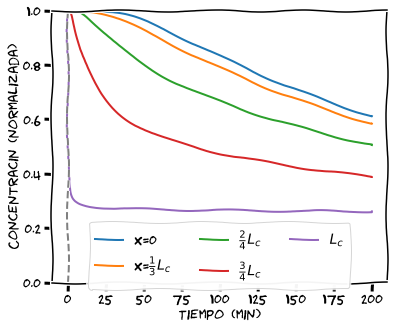

In [4]:
def diff(C, t):
    dCdt = np.zeros_like(C)
    
    dCdt[0]    = Deff * (2*C[1] - 2*C[0])/(dx**2)
    #dCdt[0]    = 0
    dCdt[1:-1] = Deff * np.diff(C, 2)/(dx**2)
    dCdt[-1]   = 0
    #dCdt[-1]   = Deff * ap * (C[-2]-C[-1])/dx
    
    return dCdt

L   = a
tau = 200*60

nx = 100
nt = 1000

X = np.linspace(0,L,nx)
t = np.linspace(0,tau,nt)

C0 = porcentajeAC*dens

dx = X[1] - X[0]
dt = t[1] - t[0]

C0     = np.ones(nx)
#C0     = C0*porcentajeAC*dens
C0[-1] = 0.256

sol = odeint(diff, C0, t, ml=1, mu=2)

t = t/60

with plt.xkcd():

    plt.figure(figsize=(6,5))
    plt.plot(t,sol[:,0], label = 'x=0')
    plt.plot(t,sol[:,int(nx*(1/4))], label = 'x=$\\frac{1}{3} L_c$')
    plt.plot(t,sol[:,int(nx*(2/4))], label = '$\\frac{2}{4} L_c$')
    plt.plot(t,sol[:,int(nx*(3/4))], label = '$\\frac{3}{4} L_c$')
    plt.plot(t,sol[:,-2], label = '$L_c$')

    plt.ylim(0,1)
    plt.axvline(0,ls='--',c='gray')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.25), shadow=False, ncol=3)

    plt.xlabel('Tiempo (min)')
    plt.ylabel('Concentración (normalizada)')

    plt.savefig('diff1.svg')

    1 - sol[-1,1:-1].mean()

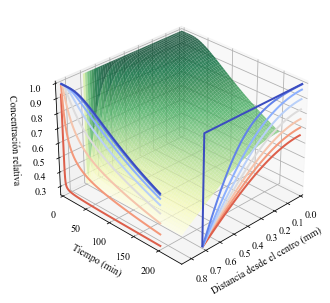

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(8,5))
ax  = fig.gca(projection='3d')

x = np.ones((nt,nx))
y = np.ones((nt,nx))
z = sol

for i in range(nt):
    x[i] = X
for i in range(nx):
    y[:,i] = t
with plt.xkcd():

    surf = ax.plot_surface(x*1000, y, z, alpha = 0.8, cmap = cm.YlGn)
    cset = ax.contour(x*1000, y, z, zdir='x', offset=a*1000*1.2, cmap=cm.coolwarm)
    cset = ax.contour(x*1000, y, z, zdir='y', offset=200*1.2, cmap=cm.coolwarm)

    ax.set_xlabel('Distancia desde el centro (mm)')
    ax.set_ylabel('Tiempo (min)')
    ax.set_zlabel('Concentración relativa')
    ax.set_ylim(0,y.max()*1.2)
    ax.set_xlim(0,1000*x.max()*1.2)
    ax.view_init(elev=None, azim=45)
    plt.savefig('diff.svg',dpi=100)

In [56]:
1-z[-1,:].mean()

0.5178758240765773

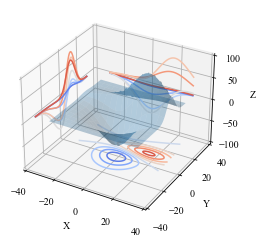

In [57]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(-40, 40)
ax.set_ylabel('Y')
ax.set_ylim(-40, 40)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)

plt.show()

## Comparación de datos experimentales con el modelo

769


/usr/lib/python3.9/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 243 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/lib/python3.9/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 179 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 243 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 179 missing from current font.
  font.set_text(s, 0.0, flags=flags)


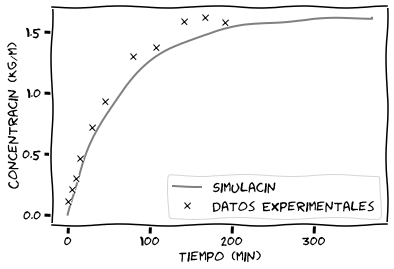

Error porcentual:  17.211322172044788
5.788295630249073
1714.3344048371007
Ka:  0.00022725193771841324


In [5]:
eps = 0.9177
# Se utilizan vales de L y A muy grandes para simular el Shod_inf

L = 300000
A = pi*(201**2)
Re = Re_f(L, A, Deq, visc, eps)
Dab = Dab_f(T, visc, rad)
Sc = Sc_f(visc, densL, Dab)
ShL = Sh_f(Re, Sc)
kL = kL_f(ShL, Dab, a)
Pe = Pe_f(Re, eps)
Dax = Dax_f(Deq, L, A, eps, Pe)
Bi = Bi_f(kL, a, Deff)
Shod = 6 
Shod = Shod_f(Bi, phi)

K = Shod*Deff/(2*a) * ap 

x0 = porcentajeAC*dens
y0 = 0
nt = 10000
t = np.linspace(0,tiempo_experimental[-1]*60,nt)

sol = odeint(batch, [x0,y0], t)

test = int(nt/len(concentracion_experimental))
print(test)

# Grafico
with plt.xkcd():

    plt.plot(t[:-10*test]/60, sol[:,1][:-10*test], label="Simulación",color='grey')
    plt.plot(tiempo_experimental[:-2], concentracion_experimental[:-2],
    marker='x',linestyle=' ', label='Datos Experimentales', color='black')
    plt.xlabel('Tiempo (min)')
    plt.ylabel('Concentración (Kg/m³)')
    plt.legend()
    plt.savefig('./figuras/datos_experimentales.svg', dpi=100)
    plt.show()

    print('Error porcentual: ',error_porcentual(sol))
    print(Shod)
    print(Bi)
    print('Ka: ', K)

## Extracciones batch

#### Ajuste de K y comparación de datos experimentales con modelo
No se utilizó ya que se usa el K calculado

In [59]:
# #### __Ajuste de K y comparación de datos experimentales con modelo__

"""'__Ajuste de K y comparación de datos experimentales con modelo__'

# Valor de la porosidad de lecho en las condiciones experimentales
eps = 0.9177
# Intervalo de tiempo en el cual resolver
t = np.linspace(0,tiempo_experimental[-1]*60,100000)
# Condiciones iniciales
x0=porcentajeAC*dens
y0=0
# Lista vacía para llenar con los valores de Ka utilizados
mat_Ka = np.array([])
# Lista vacía para llenar con los errores porcentuales correspondientes 
# a cada Ka
mat_error = np.array([])

# Iteración entre valores de Ka, 
# solución de sistema de ODEs
# Calculo de error porcentual
# Añadido de valor de Ka a lista
# Añadido de error porcentual a lista
for K in range(50000,200000,int((200000-50000)/25)):
    K = K*10**-12*ap
    sol = odeint(batch,[x0,y0],t)
    error = error_porcentual(sol)
    mat_Ka = np.append(mat_Ka, K)
    mat_error = np.append(mat_error, error)

# Graficación del error porcenctual en función de cada Ka
plt.plot(mat_Ka,mat_error)
plt.savefig('./figuras/error_ka.png')
plt.show()

# Defino K como el que dio el mínimo error cuadrado y vuelvo a calcular
K = float(mat_Ka[np.where(mat_error == mat_error.min())])

print(f'\nMínimo error porcentual: {round(mat_error.min(),2)}% con Ka = {K}\n')
del mat_Ka
del mat_error

sol = odeint(batch,[x0,y0],t)

# Grafico
plt.plot(t/60, sol[:,1], label="Simulación",color='grey')
plt.plot(tiempo_experimental, concentracion_experimental,
marker='x',linestyle=' ', label='Datos Experimentales', color='black')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.savefig('./figuras/datos_experimentales.png')
plt.show()

rendimiento_solido = 1 - sol[-1,0]/(porcentajeAC*dens)
rendimiento_liquido = sol[-1,1]*eps/(sol[0,0]*(1-eps))
print(f'''
rendimiento_l = {rendimiento_liquido}
rendimiento_s = {rendimiento_solido}
Ka: {K} s⁻¹
''')
"""

'\'__Ajuste de K y comparación de datos experimentales con modelo__\'\n\n# Valor de la porosidad de lecho en las condiciones experimentales\neps = 0.9177\n# Intervalo de tiempo en el cual resolver\nt = np.linspace(0,tiempo_experimental[-1]*60,100000)\n# Condiciones iniciales\nx0=porcentajeAC*dens\ny0=0\n# Lista vacía para llenar con los valores de Ka utilizados\nmat_Ka = np.array([])\n# Lista vacía para llenar con los errores porcentuales correspondientes \n# a cada Ka\nmat_error = np.array([])\n\n# Iteración entre valores de Ka, \n# solución de sistema de ODEs\n# Calculo de error porcentual\n# Añadido de valor de Ka a lista\n# Añadido de error porcentual a lista\nfor K in range(50000,200000,int((200000-50000)/25)):\n    K = K*10**-12*ap\n    sol = odeint(batch,[x0,y0],t)\n    error = error_porcentual(sol)\n    mat_Ka = np.append(mat_Ka, K)\n    mat_error = np.append(mat_error, error)\n\n# Graficación del error porcenctual en función de cada Ka\nplt.plot(mat_Ka,mat_error)\nplt.savefig(


    Rendimiento a epsilon: 0.677 -> 0.460
    Concentración final:   7.337 	 Kg/m³
    Volumen:               35000.000 	 m³
    

    Rendimiento a epsilon: 0.737 -> 0.486
    Concentración final:   5.787 	 Kg/m³
    Volumen:               43010.122 	 m³
    

    Rendimiento a epsilon: 0.798 -> 0.506
    Concentración final:   4.299 	 Kg/m³
    Volumen:               55774.773 	 m³
    

    Rendimiento a epsilon: 0.858 -> 0.523
    Concentración final:   2.905 	 Kg/m³
    Volumen:               79313.683 	 m³
    

    Rendimiento a epsilon: 0.918 -> 0.539
    Concentración final:   1.617 	 Kg/m³
    Volumen:               137229.232 	 m³
    


/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 243 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 179 missing from current font.
  font.set_text(s, 0.0, flags=flags)


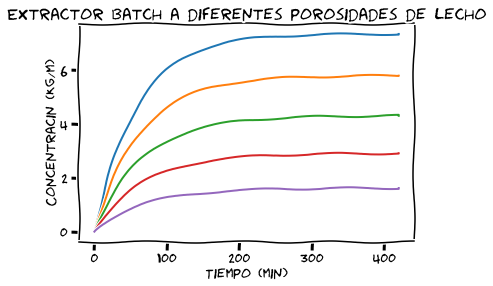

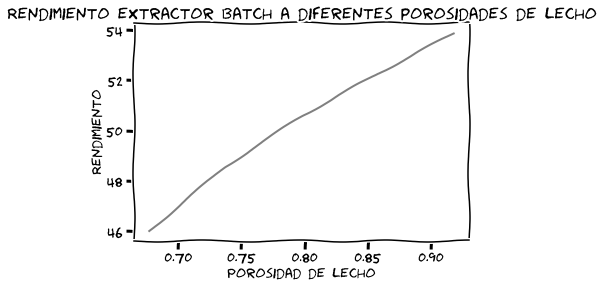

In [6]:
###########################################################################
# #### __Calculo de batchs__
###########################################################################

# Masa diaria a tratar
W = 5000/(5*4)

'__Calculo de batchs variando densidad de lecho__'

soluciones = []
rendimientos = []
epsilons = np.linspace(1-densb/dens, 0.9177, 5)
for eps in epsilons:

    nt = 10000
    tau = 7*3600
    t = np.linspace(0,tau, nt)
    x0 = porcentajeAC*dens
    y0 = 0
    
    sol = odeint(batch, [x0,y0], t)
    
    rendimiento = 1-sol[-1][0]/sol[0][0]
    rendimientos.append(round(rendimiento*100,2))

    print(f'''
    Rendimiento a epsilon: {eps:.3f} -> {1-sol[-1][0]/sol[0][0]:.3f}
    Concentración final:   {sol[-1][-1]:.3f} \t Kg/m³
    Volumen:               {W*t[-1]/((1-eps)*dens):.3f} \t m³
    ''')
    soluciones.append([eps,sol])

with plt.xkcd():

    
    for sol in soluciones:
        plt.plot(t/60, sol[1][:,1],label=f"{round(sol[0],3)}")

    plt.title("Extractor batch a diferentes porosidades de lecho")
    #plt.legend(loc='upper center', bbox_to_anchor=(0.25, +0.97), shadow=False, ncol=2)
    plt.xlabel('Tiempo (min)')
    plt.ylabel('Concentración (Kg/m³)')
    plt.savefig(f'./figuras/rendimientos_eps.{form}', dpi=dpi)
    plt.show()


    plt.plot(np.round(epsilons,3),rendimientos, color='grey')
    plt.xlabel('Porosidad de lecho')
    plt.ylabel('Rendimiento')
    plt.title("Rendimiento extractor batch a diferentes porosidades de lecho")
    plt.savefig(f'./figuras/rendimiento_extractor_batch_variando_epsilons.{form}', dpi=dpi)
    plt.show()


# Epsilon elegido para seguir trabajando
eps = 0.737

In [61]:
#### __Calculo de tres batchs en serie__

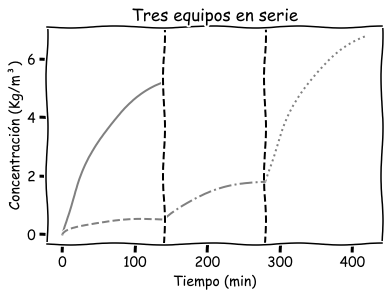


Concentración final con un equipo,    2.333 hs: 5.179917426253546
Concentración final con tres equipos: 6.754 	 Kg/m³
Rendimiento con tres equipos:         56.545 	 %
Rendimiento 1er equipo:               9.022 	 %
Rendimiento 2do equipo:               18.555 	 %
Rendimiento 3er equipo:               52.236 	 %
Volumen:                              1.704 	 m³
Volumen 3:                            0.568 	 m^3'
Mejora Porcentual con tres equipos:   16.485 	 m³



In [11]:
'__Calculo de tres batchs en serie__'

tau = 7*3600
t = np.linspace(0,tau, nt)

t1 = t[:int(nt/3)]
t2 = t[int(nt/3):int(nt*2/3)]
t3 = t[int(nt*2/3):]

sol0 = odeint(batch,[x0,y0], t)
sol1 = odeint(batch, [sol0[-1][0],y0], t1)
sol2 = odeint(batch, [sol1[-1][0],y0], t2)
sol3 = odeint(batch, [sol2[-1][0],y0], t3)

lista = []

for i in range(0,10):
    sol1 = odeint(batch, [sol2[-1][0], y0], t1)
    sol2 = odeint(batch, [sol3[-1][0], sol1[-1][1]], t2)
    sol3 = odeint(batch, [x0, sol2[-1][1]], t3)
    lista.append(sol3[-1][1])

with plt.xkcd():

    
    plt.plot(t1/60, sol0[:t1.shape[0],-1], color='grey',label = 'Único equipo')

    plt.plot(t1/60, sol1[:, -1], ls='dashed', color='grey', label='Primer equipo')
    plt.plot(t2/60, sol2[:, -1], ls='dashdot', color='grey', label="Segundo equipo")
    plt.plot(t3/60, sol3[:, -1], ls='dotted', color='grey', label="Tercer equipo")

    conc_final_3 = sol3[-1,-1]
    rendimiento_3 = 100*(1 - sol1[-1][0]/sol3[0][0])

    rendimiento_3_1 = 100*(1- sol1[-1][0]/sol1[0][0])
    rendimiento_3_2 = 100*(1- sol2[-1][0]/sol2[0][0])
    rendimiento_3_3 = 100*(1- sol2[-1][0]/sol3[0][0])

    V = W/((1-eps)*dens)


    plt.title('Tres equipos en serie')
    plt.xlabel('Tiempo (min)')
    plt.ylabel('Concentración (Kg/m³)')
    plt.axvline(t1[-1]/60, ls='dashed',color='black')
    plt.axvline(t2[-1]/60, ls='dashed',color='black')
    #plt.legend(loc='lower center', bbox_to_anchor=(0.82, +0.0), shadow=False, ncol=1)
    plt.savefig(f'./figuras/batch_serie_3.{form}', dpi=dpi)
    plt.show()

# Concentración final con un equipo, {tau/3600:.3f} hs: {sol0[-1][1]:.3f} \t Kg/m³
print(f'''
Concentración final con un equipo,    {t1[-1]/3600:.3f} hs: {sol0[t1.shape[0],1]}
Concentración final con tres equipos: {conc_final_3:.3f} \t Kg/m³
Rendimiento con tres equipos:         {rendimiento_3:.3f} \t %
Rendimiento 1er equipo:               {rendimiento_3_1:.3f} \t %
Rendimiento 2do equipo:               {rendimiento_3_2:.3f} \t %
Rendimiento 3er equipo:               {rendimiento_3_3:.3f} \t %
Volumen:                              {V:.3f} \t m³
Volumen 3:                            {V/3:.3f} \t m^3'
Mejora Porcentual con tres equipos:   {100*(sol3[-1][1]-sol0[-1][1])/sol0[-1][1]:.3f} \t m³
''')

### __Calculo de dos batchs en serie__

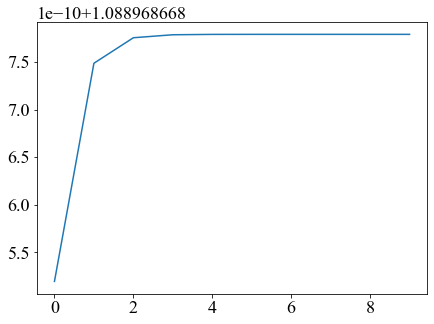

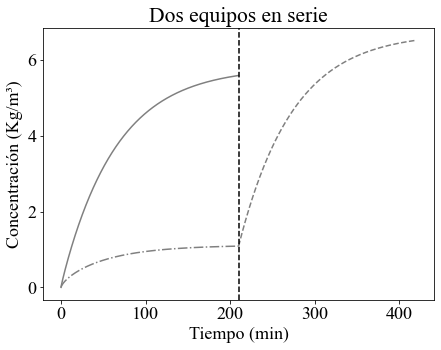


Concentración final con dos equipos:     6.522    Kg/m³
Rendimiento con dos equipos:             54.607   %
Rendimiento 1er equipo:                  16.726   %
Rendimiento 2do equipo:                  45.489   %
Volumen con un equipo:                   1.704    m³
Volumen individual dos equipos:          1.704    m³
Mejora Porcentual con dos equipos:       12.504   %



In [23]:
# #### __Calculo de dos batchs en serie__

'__Calculo de dos batchs en serie__'

convergencia = []

t1 = t[:int(nt/2)]
t2 = t[int(nt/2):]

for i in range(0,10):
    sol1 = odeint(batch, [sol2[-1][0], y0], t1)
    sol2 = odeint(batch, [x0, sol1[-1][-1]], t2)
    convergencia.append(sol1[-1][1])

plt.plot(convergencia)
plt.savefig(f'./figuras/batch_serie_2_convergencia.{form}', dpi=dpi)
plt.show()

conc_final_2 = sol2[-1][-1]
rendimiento_2 = 100*(1 - sol1[-1][0]/sol2[0][0])

rendimiento_2_1 = 100 * (1 - sol1[-1][0]/sol1[0][0])
rendimiento_2_2 = 100 * (1 - sol2[-1][0]/sol2[0][0])

V_1 = W /((1-eps)*dens)
V_2 = W /((1-eps)*dens)

# Fase Líquida
plt.plot(t[:t1.shape[0]]/60, sol0[:t1.shape[0], -1], ls='solid', color='grey', label='Único equipo')
plt.plot(t1/60, sol1[:,-1], ls='-.', color='grey', label = 'Primer equipo')
plt.plot(t2/60, sol2[:,-1], ls='--', color='grey', label = 'Segundo equipo')

plt.title('Dos equipos en serie')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.axvline(t1[-1]/60, ls='dashed',color='black')
#plt.legend()
plt.savefig(f'./figuras/batch_serie_2.{form}', dpi=dpi)
plt.show()


print(f'''
Concentración final con dos equipos:     {conc_final_2:.3f}    Kg/m³
Rendimiento con dos equipos:             {rendimiento_2:.3f}   %
Rendimiento 1er equipo:                  {rendimiento_2_1:.3f}   %
Rendimiento 2do equipo:                  {rendimiento_2_2:.3f}   %
Volumen con un equipo:                   {V_1:.3f}    m³
Volumen individual dos equipos:          {V_2:.3f}    m³
Mejora Porcentual con dos equipos:       {100*(sol2[-1][1]-sol0[-1][1])/sol0[-1][1]:.3f}   %
''')

## Extración semicontinua en columna


Materia prima diaria: 250.0 Kg
Parámetros de diseño
Largo columna:        7.07355302630646
Diámetro columna:     0.5
Flujo de solvente:    235.1789107597433

Re:   0.17217618843764468
Dab:  5.107354877977205e-11
Sc:   209253.13663163266
ShL:  59.71725477638136
kL:   4.317028070043808e-06
Pe:   0.3010730677852248
Dax:  2.9117679061433854e-06
Bi:   22.624902674915784
Shod: 5.300966452766348
Ka:   0.0002081191036401192



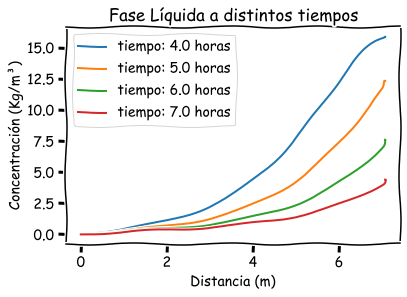

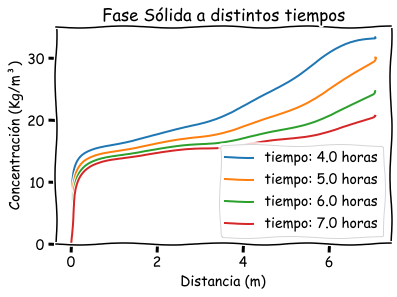

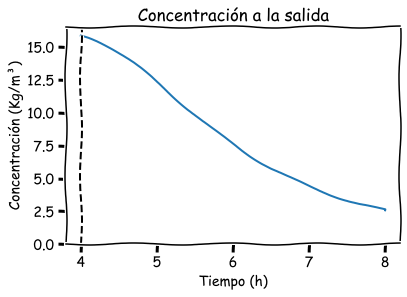


    Concentración Promedio: 8.390990603008559
    rendimiento_liquido:    0.5262357413895453
    rendimiento_solido:     0.555458987700006
    cantidad_ac:            7.893536120843179
    litros_prod:            940.7156430389732
    


In [13]:
###########################################################################
# ## __Extracción en columna__
###########################################################################

'__Definición de parámetros__'
W   = 5000/(4*5)          # Kg/día Una tonelada mensual, dividida en 4 semanas y 5 días
Dc  = 0.5                 # m
A   = pi*(Dc**2)/4 
Lc  = (W/densb)/A         # Calculo del volumen de la columna en función del volumen de materia prima a tratar
eps = 1 - densb/dens      # Asumo porosidad de lecho como la máxima alcanzable
L   = A*Lc*eps/(4*3600)   # Caudal de solvente, en m³/s
tau = 8*3600
resTimeL = A*Lc*eps/L

Re = Re_f(L, A, Deq, visc, eps)
Dab = Dab_f(T, visc, rad)
Sc = Sc_f(visc, densL, Dab)
ShL = Sh_f(Re, Sc)
kL = kL_f(ShL, Dab, a)
Pe = Pe_f(Re, eps)
Dax = Dax_f(Deq, L, A, eps, Pe)
Bi = Bi_f(kL, a, Deff)
Shod = Shod_f(Bi, phi)
K = Shod*Deff/(2*a) * ap 

print(f'''
Materia prima diaria: {W} Kg
Parámetros de diseño
Largo columna:        {Lc}
Diámetro columna:     {Dc}
Flujo de solvente:    {L*1000*3600}

Re:   {Re}
Dab:  {Dab}
Sc:   {Sc}
ShL:  {ShL}
kL:   {kL}
Pe:   {Pe}
Dax:  {Dax}
Bi:   {Bi}
Shod: {Shod}
Ka:   {K}
''')

# ### Cálculos

'___Cálculos____'

# Número de puntos
nz = 500
nt = tau

# Condiciones iniciales
eqLiq = 16.03

Z = np.linspace(0, Lc, nz)         
t = np.linspace(0, tau, nt)

dz = Z[1] - Z[0]
dt = t[1] - t[0]

F0 = np.ones(2*nz)

F0[0::2] = porcentajeAC*dens
F0[1::2] = eqLiq

sol = odeint(column, F0, t, ml=1, mu=2)

# Separo los resultados en una variable para
# las concentraciones en el sólido y otra para
# las concentraciones en el líquido

X = sol[:, 0::2]
Y = sol[:, 1::2]

# ### Gráficos columna simple

'__Obtención de gráficos__'

# Definición de un tiempo inicial para analizar y el máximo índice de z
zEnd = int(nz)
Yout = Y[:, -1]
resTimeLPos = find_nearest_pos(t, resTimeL)

# Obtengo tiempos a los cuales deseo extraerles información
tiempos = []
for i in range(resTimeLPos, int(nt), int((nt-resTimeLPos)/4)):
    tiempos.append(i)

    
with plt.xkcd():    

    # Grafico concentraciones de fase líquida
    for i in tiempos:
        plt.plot(Z[:], Y[i, :], label=f'tiempo: {round(t[i]/3600, 1)} horas')

    plt.title('Fase Líquida a distintos tiempos')
    plt.xlabel('Distancia (m)')
    plt.ylabel('Concentración (Kg/m³)')
    plt.legend()
    plt.savefig(f'./figuras/columna_simple_concentraciones_liquido.{form}', dpi=dpi)
    plt.show()


    # Grafico concentraciones de fase sólida
    for i in tiempos:
        plt.plot(Z[:], X[i, :], label=f'tiempo: {round(t[i]/3600, 1)} horas')

    plt.title('Fase Sólida a distintos tiempos')
    plt.xlabel('Distancia (m)')
    plt.ylabel('Concentración (Kg/m³)')
    plt.ylim(ymin=0)
    plt.legend()
    plt.savefig(f'./figuras/columna_simple_concentraciones_solido.{form}', dpi=dpi)
    plt.show()


    # Grafico concentración a la salida del extractor
    plt.plot(t[resTimeLPos:]/3600, Yout[resTimeLPos:], label='Fase líquida')

    plt.title('Concentración a la salida')
    plt.xlabel('Tiempo (h)')
    plt.ylabel('Concentración (Kg/m³)')
    plt.axvline(x=resTimeL/3600, color='black', ls='--', label='Tiempo de residencia del solvente')
    plt.ylim(ymin=0)
    #plt.legend()
    plt.savefig(f'./figuras/columna_simple_salida.{form}', dpi=dpi)
    plt.show()

    concentracion_promedio = Yout[resTimeLPos:].mean()
    rendimiento_liquido = L*concentracion_promedio*(t[-1] - resTimeL)/(A*Lc*densb*porcentajeAC)
    rendimiento_solido = 1 - X[-1, :].mean()/(dens*porcentajeAC)
    cantidad_ac = concentracion_promedio * L * (t[-1]-resTimeL)
    litros_prod = L * (t[-1]-resTimeL)*1000
    print(f'''
    Concentración Promedio: {concentracion_promedio}
    rendimiento_liquido:    {rendimiento_liquido}
    rendimiento_solido:     {rendimiento_solido}
    cantidad_ac:            {cantidad_ac}
    litros_prod:            {litros_prod}
    ''')

### Dos columnas en serie CC


Materia prima diaria: 250.0 Kg

_Parámetros de diseño_
Largo columna:        7.07355302630646 m
Diámetro columna:     0.5 m^2
Flujo de solvente:    235.1789107597433 L/h
Porosidad de lecho:   0.6773152629880608

_Propiedades calculadas_
Re:   0.17217618843764468
Dab:  5.107354877977205e-11
Sc:   209253.13663163266
ShL:  59.71725477638136
kL:   4.317028070043808e-06
Pe:   0.3010730677852248
Dax:  2.9117679061433854e-06
Bi:   22.610336535907496
Shod: 5.300654693687469
Ka:   0.0002081068637927959



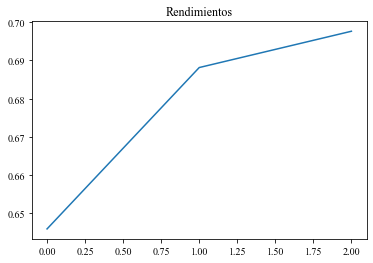

0
5760
11520
17280
23040


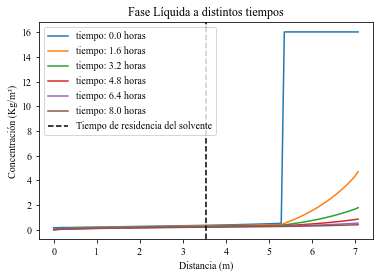

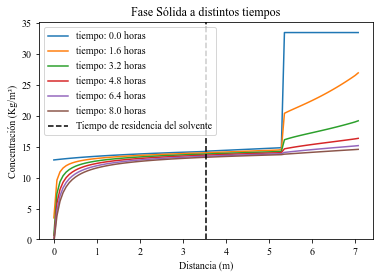

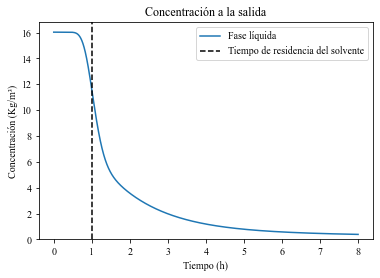


Concentración Promedio: 1.8280242243927283
rendimiento_liquido: 0.20062594810304965
rendimiento_solido: 0.6206366751198531



In [14]:
## Cálculos en dos columnas en serie CC

'__Definición de parámetros__'
W   = 5000/(4*5)          # Kg/día Una tonelada mensual, dividida en 4 semanas y 5 días
Dc  = 0.5                 # m
A   = pi*(Dc**2)/4 
Lc  = (W/densb)/A         # Calculo del volumen de la columna en función del volumen de materia prima a tratar
eps = 1 - densb/dens      # Asumo porosidad de lecho como la máxima alcanzable
L   = A*Lc*eps/(4*3600)   # Caudal de solvente, en m³/s
tau = 8*3600
resTimeL = A*Lc*eps/L/4

Re = Re_f(L, A, Deq, visc, eps)
Dab = Dab_f(T, visc, rad)
Sc = Sc_f(visc, densL, Dab)
ShL = Sh_f(Re, Sc)
kL = kL_f(ShL, Dab, a)
Pe = Pe_f(Re, eps)
Dax = Dax_f(Deq, L, A, eps, Pe)
Bi = Bi_f(kL, a, Deff)
Shod = Shod_f(Bi, phi)
K = Shod*Deff/(2*a) * ap 

print(f'''
Materia prima diaria: {W} Kg

_Parámetros de diseño_
Largo columna:        {Lc} m
Diámetro columna:     {Dc} m^2
Flujo de solvente:    {L*1000*3600} L/h
Porosidad de lecho:   {eps}

_Propiedades calculadas_
Re:   {Re}
Dab:  {Dab}
Sc:   {Sc}
ShL:  {ShL}
kL:   {kL}
Pe:   {Pe}
Dax:  {Dax}
Bi:   {Bi}
Shod: {Shod}
Ka:   {K}
''')


'____Cálculos____'
# Número de puntos
nz = 100
nt = tau

# Condiciones iniciales
eqLiq = 16.03

Z = np.linspace(0, Lc, nz)         
t = np.linspace(0*3600, tau, nt)

dz = Z[1] - Z[0]
dt = t[1] - t[0]

F0 = np.ones(2*nz)

first_column_z = int(F0.shape[0]*1/4)
second_column_z = int(F0.shape[0]*2/4)
third_column_z = int(F0.shape[0]*3/4)
end  = int(F0.shape[0]) 

F0[0::2] = porcentajeAC*dens
F0[1::2] = eqLiq

sol = odeint(column, F0, t, ml=1, mu=2)

FF = np.ones_like(F0)
sol[-1, ::] = F0[::]
rendimientos = []

for i in range(0,3):

    # Primer columna, con pre-tratamiento el día anterior
    #  Se define con las concentraciones finales de la siguiente
    FF[0:first_column_z:2]   = sol[-1, first_column_z:second_column_z:2]
    FF[1:first_column_z+1:2] = sol[-1, first_column_z+1:second_column_z:2]
    
    FF[first_column_z:second_column_z:2]   = sol[-1, second_column_z:third_column_z:2]
    FF[first_column_z+1:second_column_z:2] = sol[-1, second_column_z+1:third_column_z:2]
    
    FF[second_column_z:third_column_z:2]   = sol[-1, third_column_z:end:2]
    FF[second_column_z+1:third_column_z:2] = sol[-1, third_column_z+1:end:2]
    
    FF[third_column_z:end:2]   = porcentajeAC*dens
    FF[third_column_z+1:end:2] = eqLiq

    # Resolución del sistema
    sol = odeint(column,FF, t, ml=1, mu=2)
    
    # Tras cada iteración se calcula el rendimiento en base sólida,
    #   se considera que el sistema converge cuando el rendimiento converge 
    rendimiento_solido = 1 - (sol[-1, 0:first_column_z:2].mean()/(porcentajeAC*dens))
    rendimientos.append(rendimiento_solido)

# Grafico de convergencia
plt.plot(rendimientos)
plt.title("Rendimientos")
plt.savefig('./figuras/columnas_contraccoriente_convergencia.svg', dpi=100)
plt.show()

# Separo los resultados en una variable para
#  las concentraciones en el sólido y otra para
#  las concentraciones en el líquido
X = sol[:, ::2]
Y = sol[:, 1::2]


'__Obtención de gráficos__'

# Definición de un tiempo inicial para analizar y el máximo índice de z
zEnd = int(nz)
Yout = Y[:, -1]
resTimeLPos = find_nearest_pos(t, resTimeL)

# Obtengo tiempos a los cuales deseo extraerles información
tiempos = []
for i in range(0, int(nt), int(nt/5)):
    print(i)
    tiempos.append(i)
tiempos.append(int(nt-1))

# Grafico concentraciones de fase líquida
for i in tiempos:
    plt.plot(Z[:], Y[i, :], label=f'tiempo: {round(t[i]/3600, 1)} horas')


plt.title('Fase Líquida a distintos tiempos')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.axvline(x=Lc/2, color='black', ls='--', label='Tiempo de residencia del solvente')
plt.legend()
plt.savefig('./figuras/columnas_contracorriente_concentracion_liquida.svg', dpi=100)
plt.show()


# Grafico concentraciones de fase sólida
for i in tiempos:
    plt.plot(Z[:], X[i, :], label=f'tiempo: {round(t[i]/3600, 1)} horas')

plt.title('Fase Sólida a distintos tiempos')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.axvline(x=Lc/2, color='black', ls='--', label='Tiempo de residencia del solvente')
plt.ylim(ymin=0)
plt.legend()
plt.savefig('./figuras/columnas_contracorriente_concentracion_solida.svg', dpi=100)
plt.show()


# Grafico concentración a la salida del extractor
plt.plot(t[:]/3600, Yout[:], label='Fase líquida')

plt.title('Concentración a la salida')
plt.xlabel('Tiempo (h)')
plt.ylabel('Concentración (Kg/m³)')
plt.axvline(x=resTimeL/3600, color='black', ls='--', label='Tiempo de residencia del solvente')
plt.ylim(ymin=0)
plt.legend()
plt.savefig('./figuras/columnas_contracorriente_salida.svg',dpi=100)
plt.show()

concentracion_promedio = Yout[resTimeLPos:].mean()
rendimiento_liquido = L*concentracion_promedio*(t[-1] - resTimeL)/(A*Lc*densb*porcentajeAC)
rendimiento_solido = 1 - X[-1, :150].mean()/(dens*porcentajeAC)

print(f'''
Concentración Promedio: {concentracion_promedio}
rendimiento_liquido: {rendimiento_liquido}
rendimiento_solido: {rendimiento_solido}
''')


Materia prima diaria: 178.57142857142856 Kg
Parámetros de diseño:
Porosidad del lecho:  0.7310960524900505
Largo equipo:         4 m
Diámetro de contacto: 0.3 m
Flujo de solvente:    30.0 L/h
Tiempo Residencia L:  6.890417962713721 h
Tiempo Residencia S:  5.7001057106733235 h

Re:   0.07321072620050453
Dab:  5.107354877977205e-11
Sc:   209253.13663163266
ShL:  44.7560660911479
kL:   3.235466773275697e-06
Pe:   0.27725267681522386
Dax:  1.0379817496984382e-06
Bi:   138.53125436909593
Shod: 5.717576588769229
K:    0.0002244754659836425



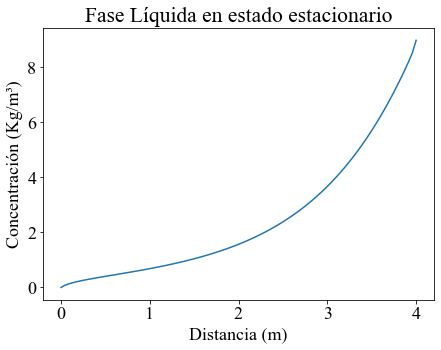

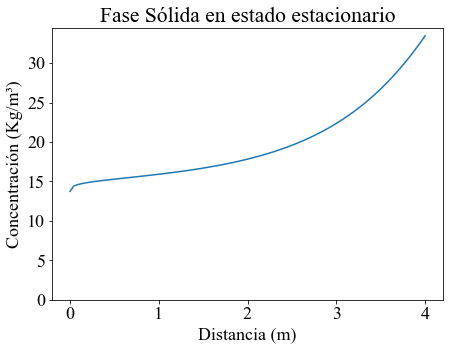

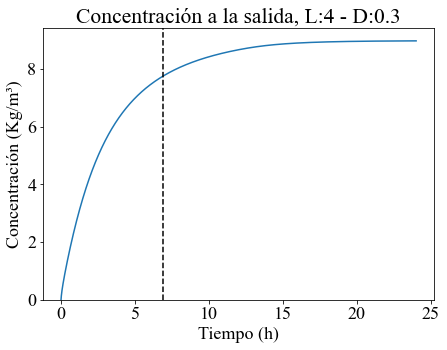


Concentración final: 8.99
rendimiento_solido: 0.5894082899248674
rendimiento_liquido: 0.6038678760942726



"solutions_CC.append(\n{\n    'X' : X,\n    'Y' : Y,\n    'Z' : Z,\n    't' : t,\n    'Lc': Lc,\n    'Dc': Dc,\n    'C_f': round(Yout[-1],2),\n    'R_s': rendimiento_solido,\n    'r_l': rendimiento_liquido,\n}\n)"

In [26]:
###########################################################################
# ## __Continuo Contracorriente__
###########################################################################

'__Redefinición de parámetros__'

Lc = 4
Dc = 30
Dc  = Dc/100

A   = pi*(Dc**2)/4
densb = 150
eps = 1 - densb/dens        
S = 5000/(4*7*24*3600)/dens
L = 30/3600/1000                   # Caudal de solvente, en m³/s
resTimeL = A*Lc*eps/L
resTimeS = A*Lc*(1-eps)/S
tau = int(5*resTimeL)

Re = Re_f(L, A, Deq, visc, eps)
Dab = Dab_f(T, visc, rad)
Sc = Sc_f(visc, densL, Dab)
ShL = Sh_f(Re, Sc)
kL = kL_f(ShL, Dab, a)
Pe = Pe_f(Re, eps)
Dax = Dax_f(Deq, L, A, eps, Pe)
Bi = kL*a/Deff
Shod = Shod_f(Bi, phi)
K = Shod*Deff/(2*a) * ap

# K que ajusta más a datos experimentales:
# K = 0.0003072868

print(f'''
Materia prima diaria: {S*24*3600*dens} Kg
Parámetros de diseño:
Porosidad del lecho:  {eps}
Largo equipo:         {Lc} m
Diámetro de contacto: {Dc} m
Flujo de solvente:    {L*1000*3600} L/h
Tiempo Residencia L:  {resTimeL/3600} h
Tiempo Residencia S:  {resTimeS/3600} h

Re:   {Re}
Dab:  {Dab}
Sc:   {Sc}
ShL:  {ShL}
kL:   {kL}
Pe:   {Pe}
Dax:  {Dax}
Bi:   {Bi}
Shod: {Shod}
K:    {K}
''')

'____Cálculos____'

# Número de puntos
nz = 100
nt = tau

# Condiciones iniciales
eqLiq = 16.03

Z = np.linspace(0, Lc, nz)         
t = np.linspace(0, tau ,nt)

dz = Z[1] - Z[0]
dt = t[1] - t[0]

F0 = np.ones(2*nz)

F0[0::2] = 0
F0[1::2] = 0
F0[1] = 0

sol = odeint(countercurrent, F0, t, ml=1, mu=2)

# Separo los resultados en una variable para
# las concentraciones en el sólido y otra para
# las concentraciones en el líquido

X = sol[:,  ::2]
Y = sol[:, 1::2]


# #### Gráficos

'__Obtención de gráficos__'

# Definición de un tiempo inicial para analizar y el máximo índice de z
zEnd = int(nz)

# Concentración a las salidas y entradas del extractor
Yin  = Y[:,  0]
Yout = Y[:, -1]
Xin  = X[:, -1]
Xout = X[:,  0]

resTimeLPos = find_nearest_pos(t, resTimeL)

# Obtengo tiempos a los cuales deseo extraerles información
tiempos = [int(t[-1]-1)]
for i in range(int(resTimeLPos/2), 2*resTimeLPos, int((nt)/4)):
    tiempos.append(i)

# Grafico concentraciones de fase líquida
#for i in tiempos:
#    plt.plot(
#        Z[0:zEnd],
#        Y[i, 0:zEnd],
#        label=f'tiempo: {round(t[i]/3600, 1)} horas'
#    )

plt.plot(Z[:zEnd], Y[-1,:zEnd])

plt.title(f'Fase Líquida en estado estacionario')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
#plt.legend()
plt.savefig(f'./figuras/contracorriente_concentracion_liquida.{form}', dpi=dpi)
plt.show()


# Grafico concentraciones de fase sólida
#for i in tiempos:
#    plt.plot(
#        Z[:zEnd],
#        X[i, 0:zEnd],
#        label=f'tiempo: {round(t[i]/3600, 1)} horas'
#    )

plt.plot(Z[:zEnd], X[-1,:zEnd])

plt.title(f'Fase Sólida en estado estacionario')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.ylim(ymin=0)
#plt.legend()
plt.savefig(f'./figuras/contracorriente_concentracion_solida.{form}', dpi=dpi)
plt.show()


# Grafico concentración a la salida del extractor
plt.plot(t[:24*3600]/3600, Yout[:24*3600], label='Fase líquida')
plt.title(f'Concentración a la salida, L:{Lc} - D:{Dc}')
plt.xlabel('Tiempo (h)')
plt.ylabel('Concentración (Kg/m³)')
plt.axvline(x=resTimeL/3600, color='black', ls='--', label='Tiempo de residencia del solvente')
plt.ylim(ymin=0)
#plt.legend()
plt.savefig(f'./figuras/contracorriente_concentracion_salida.{form}', dpi=dpi)
plt.show()


rendimiento_liquido = ((Yout[-1]-Yin[-1])*L)/(porcentajeAC*S*dens)
rendimiento_solido = 1 - Xout[-1]/(porcentajeAC*dens)

print(f'''
Concentración final: {round(Yout[-1],2)}
rendimiento_solido: {rendimiento_solido}
rendimiento_liquido: {rendimiento_liquido}
''')

"""solutions_CC.append(
{
    'X' : X,
    'Y' : Y,
    'Z' : Z,
    't' : t,
    'Lc': Lc,
    'Dc': Dc,
    'C_f': round(Yout[-1],2),
    'R_s': rendimiento_solido,
    'r_l': rendimiento_liquido,
}
)"""

In [26]:
t[3600]

3600.0290261719315

In [13]:
lenghts = []
diameters = []
concentrations = []
rends_s = []
rends_l = []
for element in solutions_CC:
    lenghts.append(element['Lc'])
    diameters.append(element['Dc'])
    concentrations.append(element['C_f'])
    rends_s.append(element['R_s'])
    rends_l.append(element['r_l'])

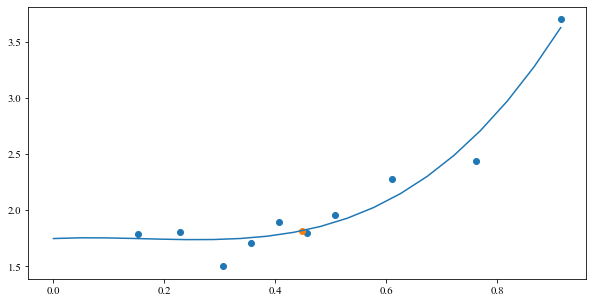

CF:  1.8171132120582743


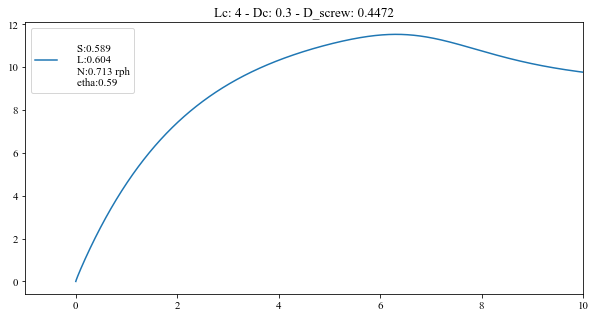

P_H:  0.3817233344026978
P_N:  105.25410740083349
P_I:  0.010136888542883093
P_T:  105.64596762377907
T:    931.1229733318773


In [14]:
# Elijo la solución que estoy usando en la tesis
sol = solutions_CC[0]

# Porcentaje de llenado de equipo
llenado = 0.45

# Area de contacto
A = pi/4*sol['Dc']**2
# Diametro real del tornillo,
#  y el paso del mismo
D_screw = np.sqrt((A/llenado)/(pi/4))
Pitch   = D_screw

# Cálculo del factor de llenado del equipo según su diámetro y llenado
capaccity_factors_ribbon=pd.DataFrame(
    [
        {'D':6*0.0254, '15%':1.32,'30%':1.52,'45%':1.79},
        {'D':9*0.0254, '15%':1.34,'30%':1.54,'45%':1.81},
        {'D':12*0.0254,'15%':1.11,'30%':1.27,'45%':1.50},
        {'D':14*0.0254,'15%':1.27,'30%':1.45,'45%':1.71},
        {'D':16*0.0254,'15%':1.55,'30%':1.69,'45%':1.90},
        {'D':18*0.0254,'15%':1.33,'30%':1.53,'45%':1.80},
        {'D':20*0.0254,'15%':1.60,'30%':1.75,'45%':1.96},
        {'D':24*0.0254,'15%':2.02,'30%':2.14,'45%':2.28},
        {'D':30*0.0254,'15%':2.16,'30%':2.29,'45%':2.44},
        {'D':36*0.0254,'15%':3.27,'30%':3.37,'45%':3.70}
    ]
)
# Realizo una regresión en la tabla
fill = '45%'
X_CF = capaccity_factors_ribbon['D']
Y_CF = capaccity_factors_ribbon[fill]
x_space = np.linspace(0, X_CF.tail(1),20)
f = np.polyfit(X_CF, Y_CF,3)
p = np.poly1d(f)

# Grafico regresión y defino el capacity factor
plt.plot(x_space,p(x_space))
plt.scatter(X_CF, Y_CF)
plt.scatter(D_screw, p(D_screw))
plt.show()
CF = p(D_screw)
print('CF: ', CF)

# Cálculo del número de revoluciones como
# $\frac{CF\cdot}{}$
N  = CF*S*dens/densb/(sol['Lc']*Pitch*A)*3600

plt.plot(
    sol['t']/3600,
    sol['Y'][:,-1],
    
    label=f"""
    S:{sol['R_s']:.3f}
    L:{sol['r_l']:.3f}
    N:{N:.3f} rph
    etha:{sol['R_s']:.2f}"""
)

plt.title(f"Lc: {sol['Lc']} - Dc: {sol['Dc']} - D_screw: {D_screw:.4f}")
plt.xlim(-1,10)
plt.legend()
plt.show()

c   = 4
Lc  = sol['Lc']+0.5/np.cos(pi/4)
P_H = (S*3600/1000)*dens*4*Lc/367*1000
P_N = D_screw*Lc/20*1000
P_I = (S*3600/1000)*dens*0.5/367*1000

print('P_H: ',P_H)
print('P_N: ',P_N)
print('P_I: ',P_I)
print('P_T: ',P_H+P_N+P_I)

T = (P_H+P_N)/N*2*pi

print('T:   ',T)

In [15]:
np.sin(np.pi/4)

0.7071067811865475

In [16]:
capaccity_factors_ribbon

,D,15%,30%,45%
0,0.1524,1.32,1.52,1.79
1,0.2286,1.34,1.54,1.81
2,0.3048,1.11,1.27,1.50
3,0.3556,1.27,1.45,1.71
4,0.4064,1.55,1.69,1.90
5,0.4572,1.33,1.53,1.80
6,0.5080,1.60,1.75,1.96
7,0.6096,2.02,2.14,2.28
8,0.7620,2.16,2.29,2.44
9,0.9144,3.27,3.37,3.70


$ \frac{CF \cdot S \cdot \frac{dens}{densb}}{L \cdot A}$

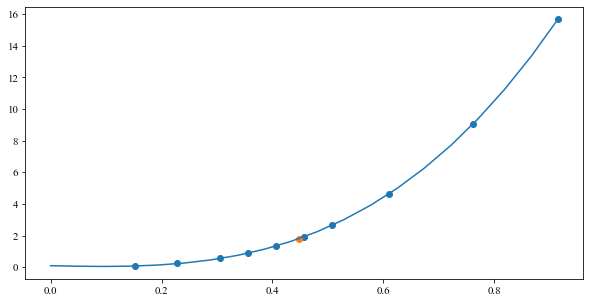

In [17]:
# calculo del numero de revoluciones necesarias segun los manuales tipicos,
#  pienso decantarme por la otra solucion mas simple (y en mi opinion mas logica) de usar los diametros y las rpm para calcular caudal

fill = 0.45
Dc=0.3
D_screw = np.sqrt((pi*(Dc/2)**2)/0.45 * 4/pi)

rpmX = np.array([6,9,12,14,16,18,20,24,30,36])*0.0254
rpmY = np.array([2.23,8.2,19.4,31.2,46.7,67.6,93.7,164,320,553.2])*0.0283168

x_space = np.linspace(0,rpmX[-1],20)

f = np.polyfit(rpmX,rpmY,3)
p = np.poly1d(f)

plt.plot(x_space,p(x_space))
plt.scatter(rpmX,rpmY)
plt.scatter(D_screw,p(D_screw))

CF_1 = 1 
CF_2 = 1.62
CF_3 = 1

N = (
    S*3600*CF_1*CF_2**CF_3*dens/densb
    )/(
    p(D_screw)
)

In [18]:
upp_limit = int(len(t)/4)
name_len = len(str(upp_limit))

for i in range(0,upp_limit,int(upp_limit/100)):
    plt.plot(
        Z[:zEnd],
        X[i, 0:zEnd],
        label='Fase Sólida'
    )
    plt.plot(
        Z[:zEnd],
        Y[i, 0:zEnd],
        label='Fase Líquida'
    )
    plt.title(f'Extractor a {round(t[i]/3600,1)} horas')
    plt.xlabel('Distancia (m)')
    plt.ylabel('Concentración (Kg/m³)')
    plt.ylim(ymin=0)
    plt.legend()
    
    pref = 'image_'+str(0)*(name_len-len(str(i)))+str(i)
    
    plt.savefig(f'./anim/{pref}.jpg')
    plt.clf()
!convert anim/*.jpg bothphases.gif
print('gif listo!')

gif listo!


<Figure size 720x360 with 0 Axes>

In [ ]:
!ffmpeg -i bothphases.gif -movflags faststart -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" video.mp4

ffmpeg version n4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-avisynth --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid --enable-nvdec --enable-nvenc --enable-omx --enable-shared --enable-version3
  lib

$\frac{dC(x,t)}{dt} = \frac{1}{x^{\phi-1}} \cdot \frac{d}{dx}(x^{\phi-1} \cdot D_{eff} \cdot \frac{dC(x,t)}{dt})$

$=xC''(x) + (\phi - 1)C'(x)$

In [ ]:
t = np.linspace(0,120*60,500000)
X = np.linspace(0,a,100000)

dx = X[1] - X[0]
dt = t[1] - t[0]

C = np.ones_like(X)
C[-1] = 0

In [ ]:
def fick(t, C, X):
    dCdt = np.empty_like(C)
    dCdt[0]   = 0
    dCdt[1:-1] = Deff/(X[1:-1]**(phi-1)) * (
        X[1:-1]**(phi-2) * np.diff(C[1:],1)/dx *\
     np.diff(C[:],2)/(dx**2) )
    
    dCdt[-1] = Deff/(X[-1]**(phi-1)) * (
    X[-1]**(phi-2) * (C[-1]-C[-2])/dx * (2*C[-1]-2*C[-2])/(dx**2))
    
    return dCdt

In [ ]:
sol = solve_ivp(fick,t,C,args=(X,))
sol

In [ ]:
sol

In [ ]:
plt.plot(X,sol['y'][:,-2])

In [ ]:
sol['y']